In [63]:
import cv2
# to install cv2 use: pip install opencv-python
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib import image

(648, 702)


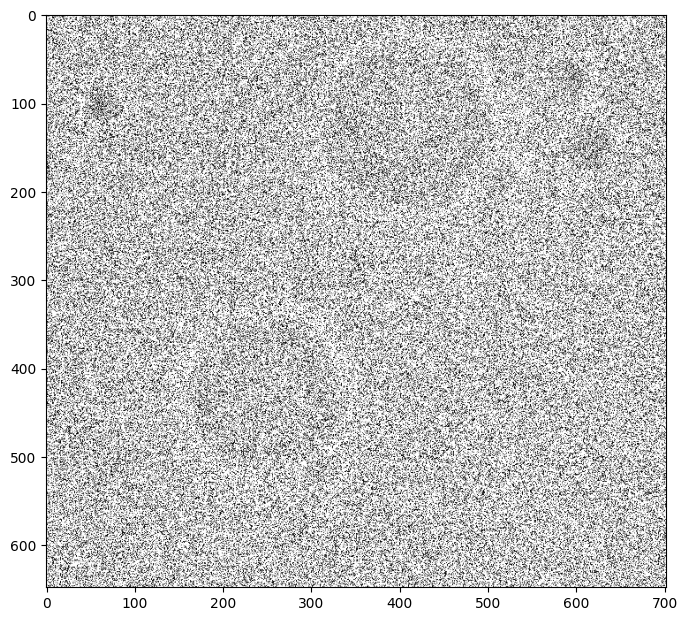

In [124]:
fname = 'Circles-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
W,H=img.shape
print(img.shape)
ratio=H/W
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')
img_original = img.copy()

# Suavizar a Imagem

In [125]:
# Gaussean Blur
m=7
Dimg = cv2.GaussianBlur(img,(m,m),0)
Dimg = cv2.GaussianBlur(Dimg, (m,m), 0)

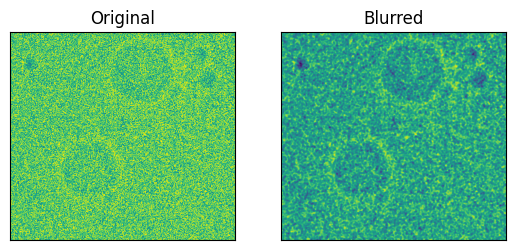

In [126]:
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(Dimg),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

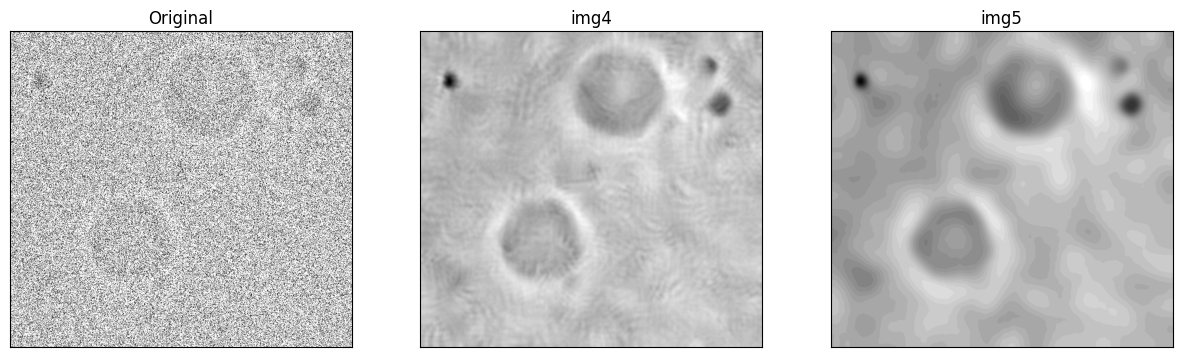

In [127]:
# OpenCV Local Denoising Filter 
img4 = cv2.fastNlMeansDenoising(Dimg,None,15,27,51)

img5 = cv2.fastNlMeansDenoising(img4,None,15,27,51)
fig = plt.figure(figsize=(15,5))
plt.subplot(131),plt.imshow(img,cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
# melhor foi este
plt.subplot(132),plt.imshow(img4,cmap='gray'),plt.title('img4')
plt.xticks([]), plt.yticks([])
# melhor também
plt.subplot(133),plt.imshow(img5,cmap='gray'),plt.title('img5')
plt.xticks([]), plt.yticks([])

plt.show()


# Low pass filter

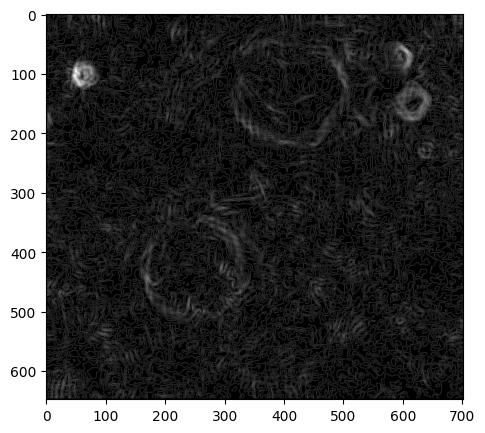

In [128]:
# correlate
def correlate (kernel, image):
    W = image.shape[0]
    H = image.shape[1]
    out =np.zeros((W,H))
    a = kernel.shape[0]%2
    b = kernel.shape[1]%2
    #print (a,b)
    for y in range(b,H-b): 
        for x in range(a,W-a): 
            for s in range (-a,a+1):
                for t in range (-b, b+1):
                    out[x,y] += (kernel[s,t]*image[x+s,y+t])
    return out

def rescale (image):
    image = np.absolute(image)
    mymin=np.amin(image)
    mymax=np.amax(image)
    W = image.shape[0]
    H = image.shape[1]
    for y in range(H): 
        for x in range(W): 
            image[x,y] = (image[x,y]-mymin)*256/(mymax-mymin)
    return image

#Laplace = np.array([[-1,-1,-1], [-1, 8, -1],[-1,-1,-1]], dtype=float)
#print(Laplace)

Sobel_y = np.array([[-1,0,1], [-2, 0, 2],[-1,0,1]], dtype=float)
Sobel_x = np.array([[-1,-2,-1], [0, 0, 0],[1,2,1]], dtype=float)

gx = correlate(Sobel_x, img4)
gx = np.absolute(gx)
gy = correlate(Sobel_y, img4)
gy = np.absolute(gy)

grad = np.sqrt(np.square(gx) + np.square(gy))
fig = plt.figure(figsize=(15,5))
plt.imshow(grad, cmap='gray')


# High Pass Filter 

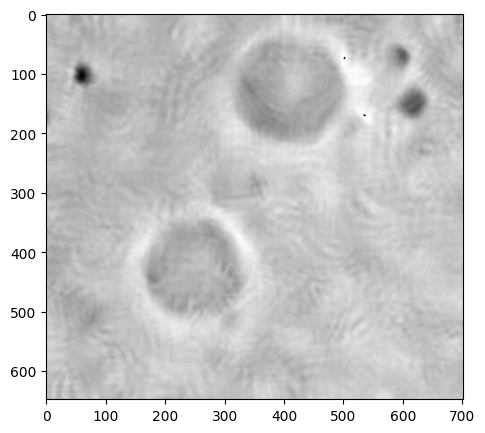

In [129]:
Laplace = np.array([[-1,-1,-1], [-1, 8, -1],[-1,-1,-1]], dtype=float)
#print(Laplace)

dImg = correlate (Laplace, img4)
dImg = rescale (img4)

fig = plt.figure(figsize=(15,5))
plt.imshow(dImg, cmap='gray')

# Notch Filter

In [130]:
# shape: (W,H) are the width and height of the filter

# d0 is the radius of the filter expressed in pixels

# u_k and v_k are the center coordinates in the Fourier image plane for the notch filter
# u_k=0, v_k=0 correspond to the center of the shifted spectrum

def notch_reject_filter_vec(shape: tuple[int, int], d0: int, u_k: int, v_k: int):
    (W, H) = shape

    H_0_u = np.repeat(np.arange(W), H).reshape((W, H))
    H_0_v = np.repeat(np.arange(H), W).reshape((H, W)).transpose()

    D_uv = np.sqrt((H_0_u - W / 2 + u_k) ** 2 + (H_0_v - H / 2 + v_k) ** 2)
    D_muv = np.sqrt((H_0_u - W / 2 - u_k) ** 2 + (H_0_v - H / 2 - v_k) ** 2)

    selector_1 = D_uv <= d0
    selector_2 = D_muv <= d0

    selector = np.logical_or(selector_1, selector_2)

    H = np.ones((W, H, 2), np.uint8)
    H[selector] = 0

    return H

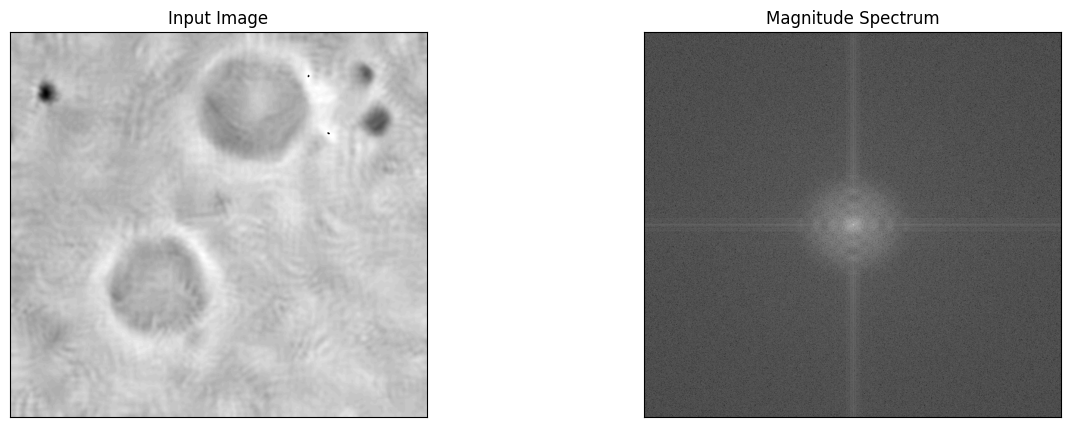

In [131]:
# convert the image representation to SPFP
img_float32 = np.float32(img4)

# compute the DFT
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_shift = np.fft.fftshift(dft)
# compute the frequency spectrum
# module of the complex value
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
magnitude_spectrum = 20*np.log(magnitude_spectrum)

# display the image and the spectrum
fig = plt.figure(figsize=(15,5))
plt.subplot(121),plt.imshow(dImg, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()  

In [132]:
# several notch filters can be composited by multiplication

# fill in the following lists to compose multiple notch filters

#d0_list = [16,12,12,12,12,12,12,12,12,12,12,16,16,12,12,12,12,12,12,12,12,12,12,16]
#u_k_list = [-85,-120,-140,-160,-180,-200,-220,-240,-260,-280,-300,-50]
#v_k_list = [0,0,0,0,0,0,0,0,0,0,0,0,85,50,30,10,-10,-30,-50,-70,-90,-110,-120,50]

d0_list = [16,16,16,16, 
             12,12,12,12,12,12,12,12,12,12, 12,12,12,12,12,12,12,12,12, 12,12,12,12,12,12,12,12,12,12]
u_k_list = [-85,-50,0,0, 
            -120,-140,-160,-180,-200,-220,-240,-260,-280,-300, 
             0,0,0,0,0,0,0,0,0,0]
v_k_list = [0,0,85,50, 
             0,0,0,0,0,0,0,0,0,0,  
            -120,-140,-160,-180,-200,-220,-240,-260,-280,-300]


H = notch_reject_filter_vec (img.shape, d0_list[0], u_k_list[0], v_k_list[0])

for d0, u_k, v_k in zip (d0_list[1:], u_k_list[1:], v_k_list[1:]):
    Haux = notch_reject_filter_vec (img.shape, d0, u_k, v_k)

    H *= Haux
    
# apply mask and inverse DFT
dft_masked = dft_shift*H
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

In [133]:
# compute the DFT of the processed image (img_back)
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft_proc = cv2.dft(img_back, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_proc_shift = np.fft.fftshift(dft_proc)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum)

In [134]:
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(H[:,:,0],2)+np.power(H[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible

mask_spectrum = 20*np.log(mask_spectrum+0.0001)

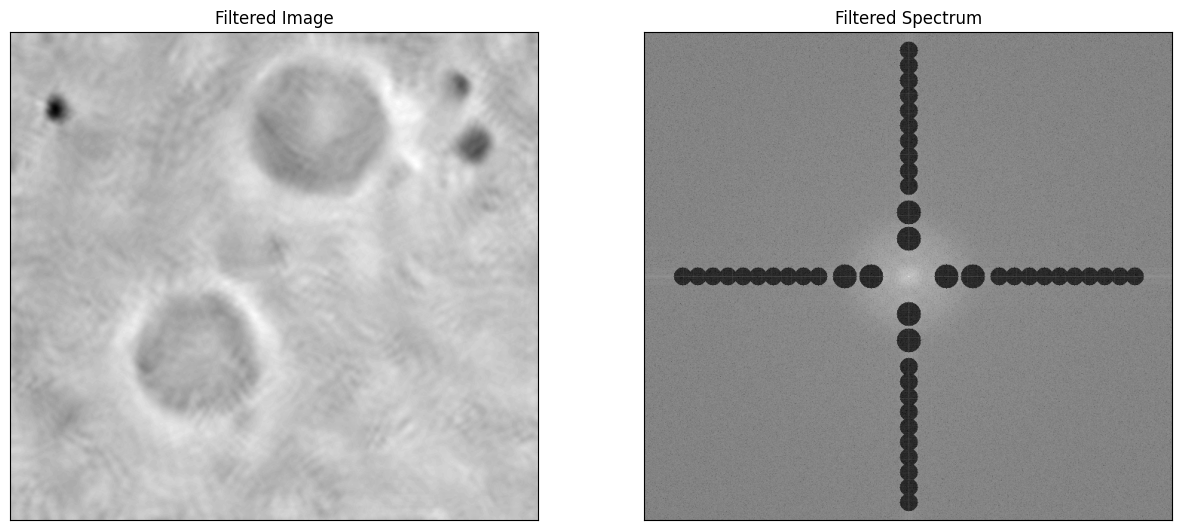

In [135]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(121),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()  

image.imsave('filtered_image.png', img_back, cmap='gray')

## Experiencia (spoiler altert: nao resultou)

(648, 702)


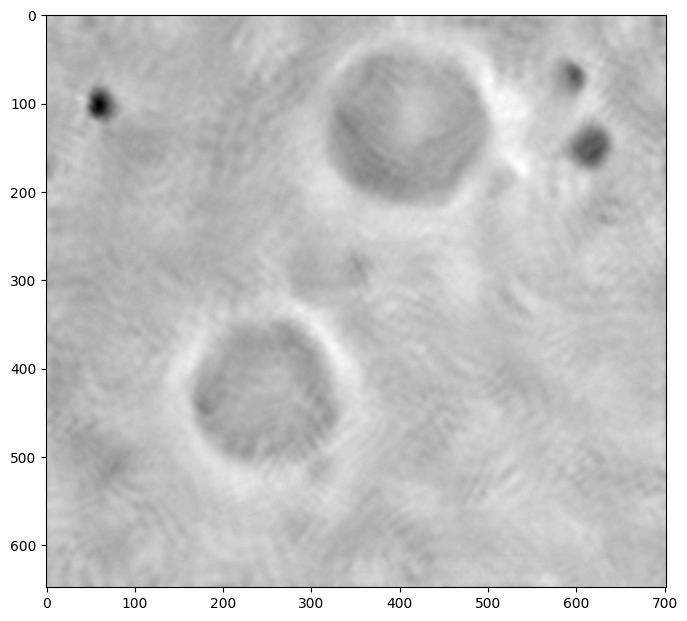

In [152]:
fname = 'filtered_image.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
W,H=img.shape
print(img.shape)
ratio=H/W
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

In [153]:
#img = np.uint8(img_back)

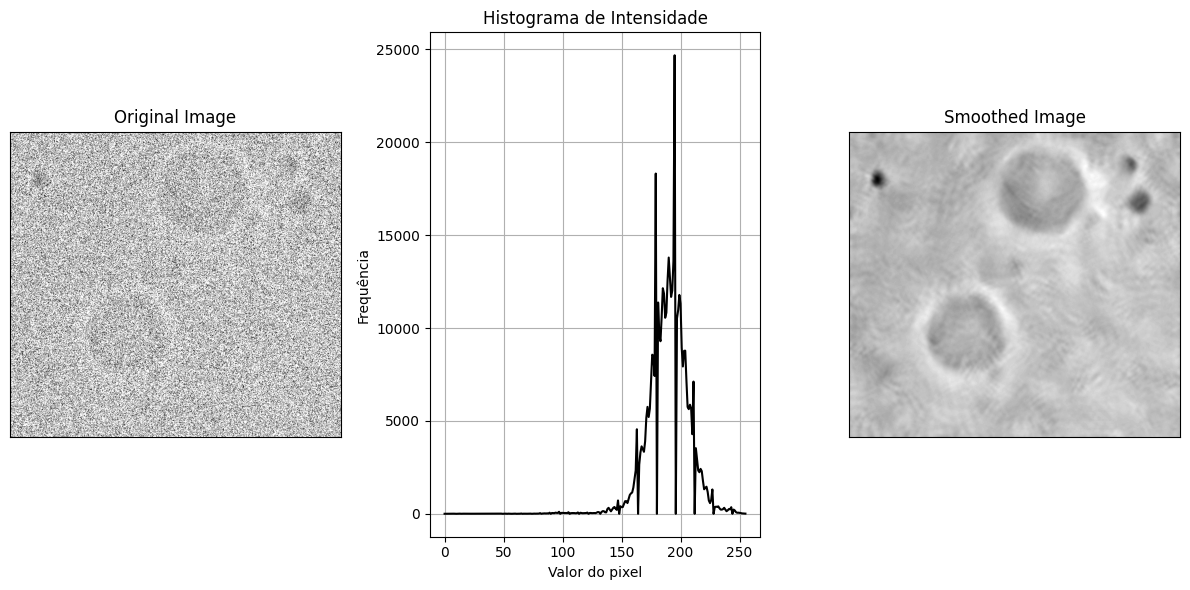

In [154]:
#img_contrast = cv2.equalizeHist(img)
#img = img_contrast.copy()
#img = cv2.fastNlMeansDenoising(img,None,15,27,50)


histogram = cv2.calcHist([img], [0], None, [256], [0, 256])

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 2)
plt.plot(histogram, color='black')
plt.xlabel('Valor do pixel')
plt.ylabel('Frequência')
plt.title('Histograma de Intensidade')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title('Smoothed Image')
plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()

In [155]:
# Low Pass Filter

# correlate
def correlate (kernel, image):
    W = image.shape[0]
    H = image.shape[1]
    out =np.zeros((W,H))
    a = kernel.shape[0]%2
    b = kernel.shape[1]%2
    #print (a,b)
    for y in range(b,H-b): 
        for x in range(a,W-a): 
            for s in range (-a,a+1):
                for t in range (-b, b+1):
                    out[x,y] += (kernel[s,t]*image[x+s,y+t])
    return out


def rescale (image):
    image = np.absolute(image)
    mymin=np.amin(image)
    mymax=np.amax(image)
    W = image.shape[0]
    H = image.shape[1]
    for y in range(H): 
        for x in range(W): 
            image[x,y] = (image[x,y]-mymin)*256/(mymax-mymin)
    return image

In [156]:
# Sobel Gradient Operators
Sobel_y = np.array([[-1,0,1], 
                    [-2, 0, 2],
                    [-1,0,1]], dtype=float)

Sobel_x = np.array([[-2,-4,-2],
                    [0, 0, 0],
                    [2,4,2]], dtype=float)

gx = correlate(Sobel_x, img)
gx = np.absolute(gx)
gy = correlate(Sobel_y, img)
gy = np.absolute(gy)

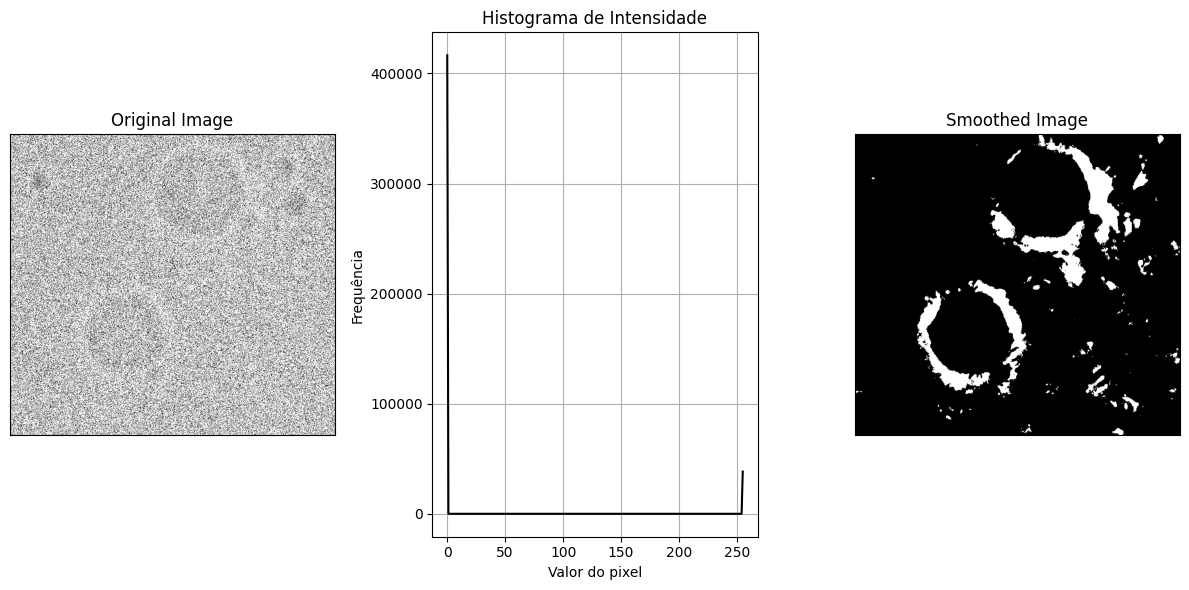

In [157]:
grad = np.sqrt(np.square(gx) + np.square(gy))
#img = np.uint8(grad)
#img_contrast = cv2.equalizeHist(img)
#img = img_contrast.copy()

ret, img = cv2.threshold(img, 210, 255, cv2.THRESH_BINARY)


histogram = cv2.calcHist([img], [0], None, [256], [0, 256])

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 2)
plt.plot(histogram, color='black')
plt.xlabel('Valor do pixel')
plt.ylabel('Frequência')
plt.title('Histograma de Intensidade')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title('Smoothed Image')
plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()

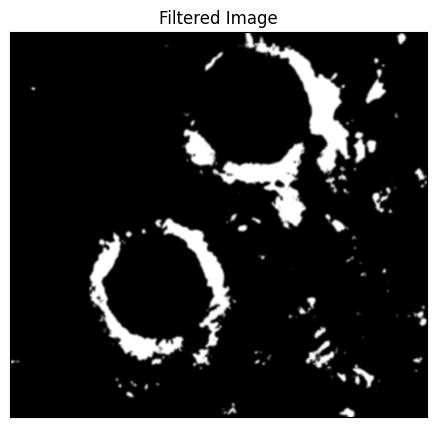

In [158]:
img = cv2.GaussianBlur(img,(m,m),0)


fig = plt.figure(figsize=(15,5))
plt.subplot(111),plt.imshow(img, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()  

Circles detected: 5


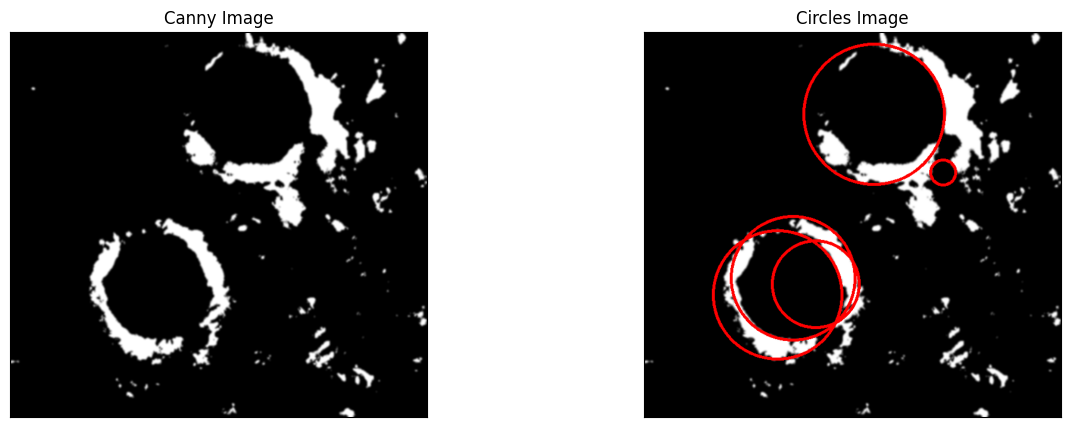

In [159]:
#img = np.uint8(img_back)

threshold_value = 18
ret, img_bin = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY)

num_circles = 0
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 30,
                               param1=75, param2=25,
                               minRadius=1, maxRadius=150)

img_circles = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        num_circles += 1
        center = (i[0], i[1])
        # circle center
        #cv.circle(img_dst, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv2.circle(img_circles, center, radius, (255, 0, 0), 3)

print('Circles detected: ' + str(num_circles))

fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Canny Image')
plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(img_circles, cmap='gray')
plt.title('Circles Image')
plt.xticks([]), plt.yticks([])
plt.show()

# GAUSSIAN LOW PASS FILTER (GLPF)

In [ ]:
# manually filter high frequencies using our own ILPF
rows, cols = img.shape
crow, ccol = rows//2 , cols//2     # center

def gaussian_filter(kernel_size, sigma=1, muu=0):
 
    # Initializing value of x,y as grid of kernel size
    # in the range of kernel size
 
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
                       np.linspace(-1, 1, kernel_size))
    dst = np.sqrt(x**2+y**2)
 
    # lower normal part of gaussian
    normal = 1/(2.0 * np.pi * sigma**2)
 
    # Calculating Gaussian filter
    gauss = np.exp(-((dst-muu)**2 / (2.0 * sigma**2))) * normal
    
    gauss = gauss / np.max(gauss)
    
    return gauss
 

# manually filter high frequencies using our own GLPF
kernel_size = 73
gaussF = gaussian_filter (kernel_size)

# create a mask first, given by the Gaussian
GLPF_mask = np.zeros((rows, cols, 2))
frows = kernel_size//2
fcols = kernel_size//2
GLPF_mask[crow-frows:crow+frows+1, ccol-fcols:ccol+fcols+1,0] = gaussF
GLPF_mask[crow-frows:crow+frows+1, ccol-fcols:ccol+fcols+1,1] = gaussF

# apply mask and inverse DFT
dft_masked = dft_shift*GLPF_mask
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

In [38]:
# compute the frequency spectrum of the MASKED_DFT, 
# just for display purposes
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_masked[:,:,0],dft_masked[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum+0.0001)
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(GLPF_mask[:,:,0],2)+np.power(GLPF_mask[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

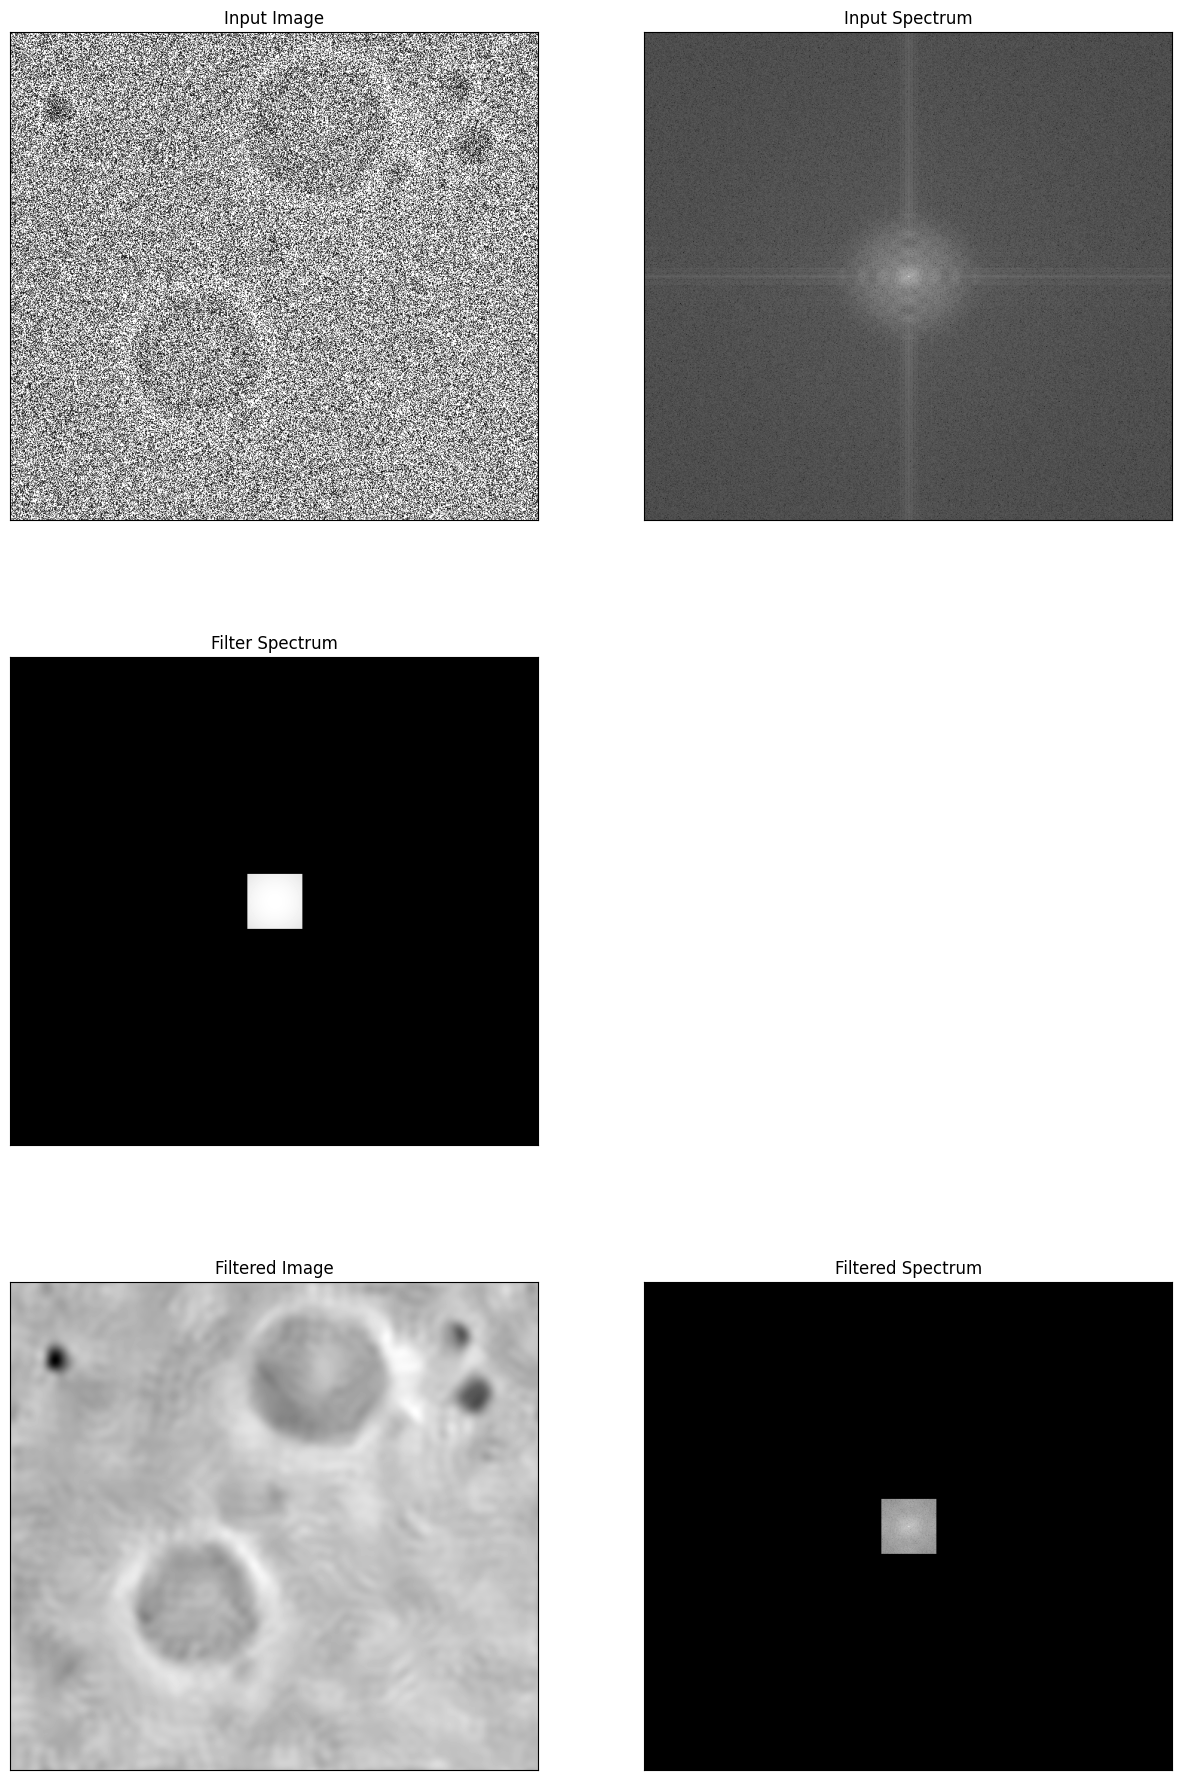

In [39]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

# Sharpen an Image

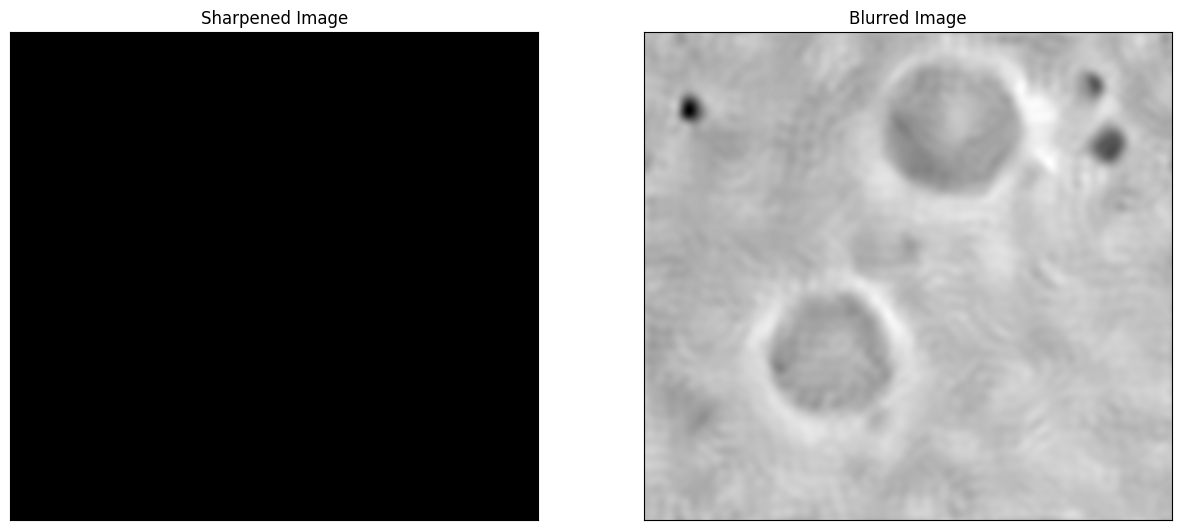

In [40]:
# Ajuste de brilho
brightness_image = cv2.convertScaleAbs(img_back, alpha=1, beta=5)

# sharpen a imagem 5
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1,9,-1], 
                              [-1,-1,-1]])

sharpened = cv2.filter2D(img_back, -1, kernel_sharpening)
sharpened = cv2.convertScaleAbs(sharpened)
edges = cv2.Canny(sharpened, 100, 200)

# melhor para compreender
fig = plt.figure(figsize=(15,15))

plt.subplot(121),plt.imshow(sharpened,cmap='gray'),plt.title('Sharpened Image')
plt.xticks([]), plt.yticks([])

kernel_3x3 = np.ones((3, 3), np.float32) / 9
blurred = cv2.filter2D(img_back, -1, kernel_3x3)
plt.subplot(122),plt.imshow(blurred,cmap='gray'),plt.title('Blurred Image')
plt.xticks([]), plt.yticks([])
plt.show()


Vou fazer para as duas, apesar de achar que a 2 se vê melhor
# Thresholding


## Adaptive

aplicavél para imagens com fundos complexos


In [41]:
# para a dImg
th2 = cv2.adaptiveThreshold(dImg,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(dImg,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

# para a dImg2

th2_2 = cv2.adaptiveThreshold(dImg2,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3_2 = cv2.adaptiveThreshold(dImg2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
plt.figure(figsize=(20, 20))
plt.subplot(151),plt.imshow(img,cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
# melhor foi este
plt.subplot(152),plt.imshow(th2,cmap='gray'),plt.title('atmean_th2')
plt.xticks([]), plt.yticks([])
# melhor também
plt.subplot(153),plt.imshow(th3,cmap='gray'),plt.title('atgaussian_th3')
plt.xticks([]), plt.yticks([])

#pessimo
plt.subplot(154),plt.imshow(th2_2,cmap='gray'),plt.title('atmean_th2_2')
plt.xticks([]), plt.yticks([])
plt.subplot(155),plt.imshow(th3_2,cmap='gray'),plt.title('atgaussian_th3_2')
plt.xticks([]), plt.yticks([])
plt.show()

NameError: name 'dImg2' is not defined

## Otsu's 

são utilizados para determinar automaticamente os melhores valores de threshold, tornando o processo mais eficiente e menos dependente de ajustes manuais

In [ ]:
# para a dImg
# Otsu's thresholding
ret2,th2 = cv2.threshold(dImg,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(dImg,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# para a dImg2

# Otsu's thresholding
ret2_2,th2_2 = cv2.threshold(dImg2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(dImg2,(5,5),0)
ret3_2,th3_2 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize=(20, 20))
plt.subplot(151),plt.imshow(img,cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
# melhor foi este
plt.subplot(152),plt.imshow(th2,cmap='gray'),plt.title('atmean_th2')
plt.xticks([]), plt.yticks([])
# melhor também
plt.subplot(153),plt.imshow(th3,cmap='gray'),plt.title('atgaussian_th3')
plt.xticks([]), plt.yticks([])

#pessimo
plt.subplot(154),plt.imshow(th2_2,cmap='gray'),plt.title('atmean_th2_2')
plt.xticks([]), plt.yticks([])
plt.subplot(155),plt.imshow(th3_2,cmap='gray'),plt.title('atgaussian_th3_2')
plt.xticks([]), plt.yticks([])
plt.show()

# Edge detection

In [ ]:
# correlate
def correlate (kernel, image):
    W = image.shape[0]
    H = image.shape[1]
    out =np.zeros((W,H))
    a = kernel.shape[0]%2
    b = kernel.shape[1]%2
    #print (a,b)
    for y in range(b,H-b): 
        for x in range(a,W-a): 
            for s in range (-a,a+1):
                for t in range (-b, b+1):
                    out[x,y] += (kernel[s,t]*image[x+s,y+t])
    return out

In [ ]:
def rescale (image):
    image = np.absolute(image)
    mymin=np.amin(image)
    mymax=np.amax(image)
    W = image.shape[0]
    H = image.shape[1]
    for y in range(H): 
        for x in range(W): 
            image[x,y] = (image[x,y]-mymin)*256/(mymax-mymin)
    return image

In [ ]:
Laplace = np.array([[-1,-1,-1], [-1, 8, -1],[-1,-1,-1]], dtype=float)
#print(Laplace)
dImg = correlate (Laplace, dImg2)
dImg = rescale (dImg)
fig = plt.figure(figsize=(15,5))
plt.imshow(dImg, cmap='gray')

#th2
dImg = correlate (Laplace, th2)
dImg = rescale (dImg)
fig = plt.figure(figsize=(15,5))
plt.imshow(dImg, cmap='gray')

## Canny edge detection

In [ ]:
dImg = cv2.convertScaleAbs(dImg)
edges = cv2.Canny(dImg,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
dImg = cv2.convertScaleAbs(th2)
edges = cv2.Canny(dImg, 100, 200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
dImg = cv2.convertScaleAbs(th3)
edges = cv2.Canny(dImg, 100, 200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
dImg = cv2.convertScaleAbs(th2_2)
edges = cv2.Canny(dImg, 100, 200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
dImg = cv2.convertScaleAbs(th3_2)
edges = cv2.Canny(dImg, 100, 200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Circle Detection

In [ ]:
fname = 'original.jpg'
image_original = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
W,H=img.shape
print(image_original.shape)
ratio=H/W
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(image_original, cmap='gray')

th2_2 = th2_2

In [ ]:
# Obter as dimensões da imagem
altura, largura = th3_2.shape
print("Dimensões da imagem: {} x {} (pixels)".format(largura, altura))
thresh1_1 = th2_2

In [ ]:
# Definir valores para os parâmetros
#image = th3.copy()
thresh1 = thresh1_1.copy() # para testar a deteção dos circulos
dp = 1
minDist = 30
param1 = 75
param2 = 25
minRadius = 1
maxRadius = 150
num_circles_detected = 0

# Detectar círculos
circles = cv2.HoughCircles(thresh1_1, cv2.HOUGH_GRADIENT, dp, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

# Verificar se círculos foram detectados
if circles is not None:
    # Converter para inteiros
    circles = np.uint16(np.around(circles))
    
    # Iterar sobre os círculos detectados
    for circle in circles[0, :]:
        x, y, raio = circle
        # Desenhar o círculo na imagem original
        cv2.circle(thresh1_1, (x, y), raio, (0, 255, 0), 2)
        
        # Imprimir as coordenadas dos círculos
        print("Círculo detectado: Centro ({}, {}), Raio {}".format(x, y, raio))
        num_circles_detected += 1
        
    cv2.imwrite('circlesDetected.jpg', thresh1_1)
    print("Número de círculos detectados:", num_circles_detected)
    
else:
    print("Nenhum círculo detectado.")